In [133]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
from collections import defaultdict

import xgboost as xgb

pd.set_option('display.max_columns', None)

np.random.seed(2131)

import warnings
warnings.filterwarnings('ignore')

%run ../src/season.py

** Load data files. **

In [2]:
teams               = pd.read_csv('../data/Teams.csv')
seasons             = pd.read_csv('../data/Seasons.csv')
reg_season_compact  = pd.read_csv('../data/RegularSeasonCompactResults.csv')
reg_season_detailed = pd.read_csv('../data/RegularSeasonDetailedResults.csv')
tourney_compact     = pd.read_csv('../data/TourneyCompactResults.csv')
tourney_detailed    = pd.read_csv('../data/TourneyDetailedResults.csv')
tourney_seeds       = pd.read_csv('../data/TourneySeeds.csv')
tourney_slots       = pd.read_csv('../data/TourneySlots.csv')

### Exploratory Data Analysis

In [3]:
# let's look at a single season (2011) e.g :P
reg_season_2011      = reg_season_compact.loc[reg_season_compact.Season == 2011, :]
tourney_compact_2011 = tourney_compact.loc[tourney_compact.Season == 2011, :]

In [4]:
Counter(reg_season_2011.Wteam)

Counter({1102: 14,
         1103: 22,
         1104: 21,
         1105: 10,
         1106: 15,
         1107: 16,
         1108: 4,
         1110: 22,
         1111: 14,
         1112: 27,
         1113: 12,
         1114: 17,
         1115: 7,
         1116: 18,
         1117: 15,
         1119: 10,
         1120: 10,
         1122: 18,
         1123: 18,
         1124: 17,
         1125: 30,
         1126: 17,
         1127: 8,
         1129: 19,
         1130: 20,
         1131: 21,
         1132: 13,
         1133: 11,
         1135: 10,
         1136: 8,
         1137: 25,
         1138: 17,
         1139: 22,
         1140: 29,
         1141: 9,
         1142: 15,
         1143: 17,
         1144: 11,
         1145: 15,
         1146: 2,
         1147: 1,
         1148: 19,
         1149: 12,
         1150: 10,
         1151: 14,
         1152: 4,
         1153: 25,
         1154: 8,
         1155: 21,
         1156: 24,
         1157: 24,
         1158: 24,
         1159: 7,
   

** Class representing season statistics **

In [121]:
class SeasonStats:
    def __init__(self, data):
        self.data = data
    
    @staticmethod
    def get_total_teams(wins_dict, loss_dict):
        return set(list(wins_dict.keys()) + list(loss_dict.keys()))
    
    def get_total_points(self):
        wteam_points = self.data.groupby('Wteam')['Wscore'].sum()
        lteam_points = self.data.groupby('Lteam')['Lscore'].sum()
        
        return wteam_points + lteam_points # pandas series
    
    def get_field_goals_attempt_ratio(self):
        wfgm = self.data.groupby('Wteam')['Wfgm'].sum()
        lfgm = self.data.groupby('Lteam')['Lfgm'].sum()
        
        wfga = self.data.groupby('Wteam')['Wfga'].sum()
        lfga = self.data.groupby('Lteam')['Lfga'].sum()
        
        return (wfgm + lfgm) / (wfga + lfga) # pandas series
    
    def get_off_rebounds(self):
        wor = self.data.groupby('Wteam')['Wor'].sum()
        lor = self.data.groupby('Lteam')['Lor'].sum()
        
        return wor + lor
    
    def get_def_rebounds(self):
        wdr = self.data.groupby('Wteam')['Wdr'].sum()
        ldr = self.data.groupby('Lteam')['Ldr'].sum()
        
        return wdr + ldr
    
    def winning_margin(self):
        w_margin = self.data.groupby('Wteam')[['Wscore', 'Lscore']]\
                      .apply(lambda x: (x['Wscore'] - x['Lscore']).sum())
        return w_margin
    
    def loss_margin(self):
        l_margin = self.data.groupby('Lteam')[['Wscore', 'Lscore']]\
                       .apply(lambda x: (x['Lscore'] - x['Wscore']).sum())
        
        return l_margin
    
    def number_of_home_wins(self):
        return self.data.groupby('Wteam')[['Wloc']]\
                   .apply(lambda x: (x['Wloc'] == 'H').sum())
    
    def number_of_away_wins(self):
        return self.data.groupby('Wteam')[['Wloc']]\
                   .apply(lambda x: (x['Wloc'] == 'A').sum())
    
    def get_three_pointer_ratio(self):
        wfgm3 = self.data.groupby('Wteam')['Wfgm3'].sum()
        lfgm3 = self.data.groupby('Lteam')['Lfgm3'].sum()
        
        wfga3 = self.data.groupby('Wteam')['Wfga3'].sum()
        lfga3 = self.data.groupby('Lteam')['Lfga3'].sum()
        
        return (wfgm3 + lfgm3) / (wfga3 + lfga3) # pandas series
    
    def get_leaderboard(self):
        wins_dict = Counter(self.data.Wteam)
        loss_dict = Counter(self.data.Lteam)
        
        total_teams = SeasonStats.get_total_teams(wins_dict, loss_dict)
        
        leaderboard = defaultdict(list)
        
        for team in total_teams:
            num_wins = wins_dict[team] if team in wins_dict else 0
            num_loss = loss_dict[team] if team in loss_dict else 0
            
            leaderboard[team] = [num_wins, num_loss]
        
        self.leaderboard = leaderboard
        
        return self.leaderboard
    
    def sort_leaderboard(self, leaderboard):
        return np.array(sorted(leaderboard, 
                      key=lambda x: leaderboard[x][0] - leaderboard[x][1], 
                      reverse=True))
    
    def top_n_teams(self, sorted_leaderboard, n):
        return sorted_leaderboard[:n]

In [35]:
reg_season_2003 = reg_season_detailed.loc[reg_season_detailed.Season == 2003, :]
tourney_2003    = tourney_detailed.loc[tourney_detailed.Season == 2003, :]

In [122]:
reg_season_stats    = SeasonStats(reg_season_2003)
leaderboard         = reg_season_stats.get_leaderboard()
sorted_leaderboard  = reg_season_stats.sort_leaderboard(leaderboard)
top_32_teams        = reg_season_stats.top_n_teams(sorted_leaderboard, 32)
total_points        = reg_season_stats.get_total_points()
field_goals_ratio   = reg_season_stats.get_field_goals_attempt_ratio()
three_pointer_ratio = reg_season_stats.get_three_pointer_ratio()
home_wins           = reg_season_stats.number_of_home_wins()
away_wins           = reg_season_stats.number_of_away_wins()
off_rebounds        = reg_season_stats.get_off_rebounds()
def_rebounds        = reg_season_stats.get_def_rebounds()
w_margin            = reg_season_stats.winning_margin()
l_margin            = reg_season_stats.loss_margin()

In [78]:
tourney_detailed.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,Wfgm3,Wfga3,Wftm,Wfta,Wor,Wdr,Wast,Wto,Wstl,Wblk,Wpf,Lfgm,Lfga,Lfgm3,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


In [123]:
tourney_stats               = SeasonStats(tourney_2003)
tourney_leaderboard         = tourney_stats.get_leaderboard()
sorted_tourney_leaderboard  = tourney_stats.sort_leaderboard(tourney_leaderboard)

** Hypothesis - 1 **
- In tournament for every match team that has higher rank after regular season would win over the other.

In [31]:
def get_actual_outcome(tournament_matchups, sorted_leaderboard):
    return np.array([1 if wteam < lteam else 0 for wteam, lteam in tournament_matchups.values ])

In [60]:
def league_rank_effect(tournament_matchups, sorted_leaderboard):
    predicted_outcome = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_league_rank = np.where(sorted_leaderboard == wteam)[0][0]
        lteam_league_rank = np.where(sorted_leaderboard == lteam)[0][0]
        
        if wteam_league_rank < lteam_league_rank: # lower rank is actually better
            predicted_outcome.append(1)
        else:
            predicted_outcome.append(0)
        
    predicted_outcome = np.array(predicted_outcome)
    return predicted_outcome

In [61]:
def get_diff_in_league_ranks(tournament_matchups, sorted_leaderboard):
    diff_in_league_ranks = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_league_rank = np.where(sorted_leaderboard == wteam)[0][0]
        lteam_league_rank = np.where(sorted_leaderboard == lteam)[0][0]
            
        diff_in_league_ranks.append(wteam_league_rank - lteam_league_rank)
    
    return np.array(diff_in_league_ranks)

In [131]:
actual_outcome = get_actual_outcome(tourney_compact_2011[['Wteam', 'Lteam']],
                                    sorted_leaderboard
                                   )

In [109]:
predicted_outcome = league_rank_effect(tourney_compact_2011[['Wteam', 'Lteam']], 
                                       sorted_leaderboard)
print('Success rate: {}'.format(np.sum(predicted_outcome) / len(predicted_outcome)))

Success rate: 0.6119402985074627


In [99]:
diff_in_league_ranks = get_diff_in_league_ranks(tourney_compact_2011[['Wteam', 'Lteam']],
                                                sorted_leaderboard)

print(diff_in_league_ranks)

[  20   -7  -44  -71   37  -78  -30    2 -128  -26   55    7   17 -139  -38
  -77 -101  -76   19   38  -21  -29   20  -60   69  -86   75  -19   10  -50
 -147  -74  -84  -21   -3  -15   38  -37    1  -38  -57  -34  -19  -19   -4
 -101   45 -101   85  -35  -10   35    6    5   22   10  -13   25  -86   -2
   30   14    9   55   -9   -2  -22]


** As we can see 61% of the time team with lower rank wins over the other. **

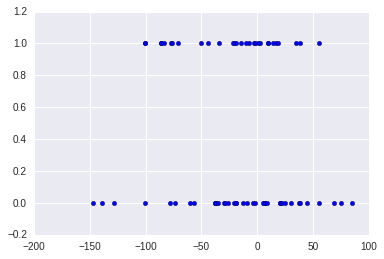

In [111]:
plt.scatter(diff_in_league_ranks, actual_outcome);

** Basic Logistic Regression Model **

In [123]:
X = diff_in_league_ranks.reshape(-1, 1)
y = actual_outcome

In [124]:
log = LogisticRegression(C=.1)
log.fit(X, y)
predicted_probs = log.predict_proba(X)[:, 1]

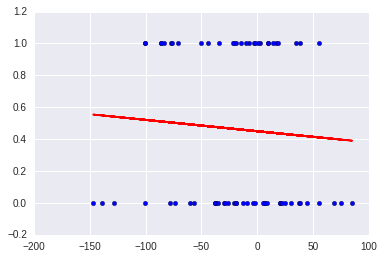

In [125]:
plt.scatter(diff_in_league_ranks, actual_outcome)
plt.plot(diff_in_league_ranks, predicted_probs, 'r');

** Split into train and test set **

In [126]:
Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

In [127]:
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.7027375130625296


** Hypothesis - 2 **

If a team is one of the top-32 teams from regular divisions then it has high chance of winning

In [62]:
def top_32_team_effect(tournament_matchups, sorted_leaderboard):
    top_32_flag = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_league_rank = np.where(sorted_leaderboard == wteam)[0][0]
        lteam_league_rank = np.where(sorted_leaderboard == lteam)[0][0]
        
        top_32_flag.append([int(wteam_league_rank < 32),
                                  int(lteam_league_rank < 32)
                                 ])
    
    top_32_flag = np.array(top_32_flag)
    return top_32_flag

In [140]:
top_32_flag = top_32_team_effect(tourney_compact_2011[['Wteam', 'Lteam']],
                                 sorted_leaderboard
                                )

In [142]:
X = top_32_flag
y = actual_outcome

In [143]:
Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

In [144]:
log = LogisticRegression()
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.6975540288580674


In [147]:
rf = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1)
rf.fit(Xtr, ytr)
yhat = rf.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.6880518988356671


** Hypothesis - 3 **

Total points scored in regular season has an impact on the NCAA tournament

In [63]:
def total_points_effect(tournament_matchups, total_points):
    points = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_points      = total_points.ix[wteam]
        lteam_points      = total_points.ix[lteam]
        
        points.append([wteam_points, lteam_points])
    
    points = np.array(points)
    return points

In [170]:
points = total_points_effect(tourney_compact_2011[['Wteam', 'Lteam']],
                             total_points
                            )

In [172]:
X = points
y = actual_outcome

In [173]:
Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

In [174]:
log = LogisticRegression()
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.710631017657268


In [175]:
rf = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1)
rf.fit(Xtr, ytr)
yhat = rf.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.5742303721724253


** Hypothesis - 4 **

Field goals made and field goals attempted in regular season will make an impact.

In [64]:
def attempt_ratio_effect(tournament_matchups, attempt_ratios):
    ratios = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_attempt_ratio      = attempt_ratios.ix[wteam]
        lteam_attempt_ratio      = attempt_ratios.ix[lteam]
        
        ratios.append([wteam_attempt_ratio, lteam_attempt_ratio])
    
    ratios = np.array(ratios)
    return ratios

In [64]:
attempt_ratios = attempt_ratio_effect(tourney_2003[['Wteam', 'Lteam']],
                             field_goals_ratio
                            )

In [65]:
actual_outcome = get_actual_outcome(tourney_2003[['Wteam', 'Lteam']],
                                    sorted_leaderboard
                                   )

In [67]:
X = attempt_ratios
y = actual_outcome

Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

log = LogisticRegression()
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

rf = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1)
rf.fit(Xtr, ytr)
yhat = rf.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.6734186047761413
Log-loss score on the validation set: 0.6163336805788261


** Hypothesis - 5 **

In [65]:
def three_pointer_ratio_effect(tournament_matchups, three_pointer_ratio):
    ratios = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_three_pointer_attempt_ratio      = three_pointer_ratio.ix[wteam]
        lteam_three_pointer_attempt_ratio      = three_pointer_ratio.ix[lteam]
        
        ratios.append([wteam_three_pointer_attempt_ratio, 
                       lteam_three_pointer_attempt_ratio])
    
    ratios = np.array(ratios)
    return ratios

In [86]:
three_pointer_ratios = three_pointer_ratio_effect(tourney_2003[['Wteam', 'Lteam']],
                        three_pointer_ratio
                            )

In [87]:
actual_outcome = get_actual_outcome(tourney_2003[['Wteam', 'Lteam']],
                                    sorted_leaderboard
                                   )

In [88]:
X = three_pointer_ratios
y = actual_outcome

Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

log = LogisticRegression()
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

rf = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1)
rf.fit(Xtr, ytr)
yhat = rf.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.6742032349125562
Log-loss score on the validation set: 0.7779976829551897


** Hypothesis - 6 **

Number of home wins will have an impact on the form of team coming into the tournament.

In [66]:
def home_wins_effect(tournament_matchups, home_wins):
    num_home_wins = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_home_wins      = home_wins.ix[wteam]
        lteam_home_wins      = home_wins.ix[lteam]
        
        num_home_wins.append([wteam_home_wins, 
                       lteam_home_wins])
    
    num_home_wins = np.array(num_home_wins)
    return num_home_wins

In [133]:
num_home_wins = home_wins_effect(tourney_2003[['Wteam', 'Lteam']],
                        home_wins
                            )

In [130]:
actual_outcome = get_actual_outcome(tourney_2003[['Wteam', 'Lteam']],
                                   sorted_leaderboard
                                   )

In [134]:
X = num_home_wins
y = actual_outcome

Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

log = LogisticRegression()
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

rf = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1)
rf.fit(Xtr, ytr)
yhat = rf.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.5839058926962051
Log-loss score on the validation set: 0.6302330133151852


** Hypothesis - 7 **

Number of away wins scored in the regular season will have an impact on how the team plays in the tournament.

In [67]:
def away_wins_effect(tournament_matchups, away_wins):
    num_away_wins = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_away_wins      = away_wins.ix[wteam]
        lteam_away_wins      = away_wins.ix[lteam]
        
        num_away_wins.append([wteam_away_wins, 
                       lteam_away_wins])
    
    num_away_wins = np.array(num_away_wins)
    return num_away_wins

In [157]:
num_away_wins = away_wins_effect(tourney_2003[['Wteam', 'Lteam']],
                        away_wins
                            )
actual_outcome = get_actual_outcome(tourney_2003[['Wteam', 'Lteam']],
                                   sorted_leaderboard
                                   )

In [158]:
X = num_away_wins
y = actual_outcome

Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

log = LogisticRegression()
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

rf = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1)
rf.fit(Xtr, ytr)
yhat = rf.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.6555185419540128
Log-loss score on the validation set: 0.5207589573916594


** Hypothesis - 8 **

How many has this team appeared in the tournament will have an effect on the outcome ?

In [27]:
def get_ncaa_tournament_appearances(ncaa_tournament):
    """
    Returns dict of teams with number of appearances in NCAA tournaments
    
    :param ncaa_tournament: Dataframe representing NCAA tournaments
    :return dict: Dictionary representing teams with number of appearances in the tournament
    
    """
    
    team_appearances = defaultdict(int)
    
    for wteam, lteam in ncaa_tournament[['Wteam', 'Lteam']].values:
        team_appearances[wteam] += 1
        team_appearances[lteam] += 1
    
    return team_appearances

In [28]:
ncaa_tournament  = tourney_compact.loc[tourney_compact.Season < 2003, ['Wteam', 'Lteam']]
team_appearances = get_ncaa_tournament_appearances(ncaa_tournament)

In [43]:
# team with most appearances in the tournament
most_appearances = sorted(team_appearances, 
                          key=lambda x: team_appearances[x], 
                          reverse=True)

In [55]:
def presence_in_tournament_effect(tournament_matchups, team_appearances):
    past_presence = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_past_presence      = team_appearances[wteam] if wteam in team_appearances else 0
        lteam_past_presence      = team_appearances[lteam] if lteam in team_appearances else 0
        
        past_presence.append([wteam_past_presence,
                              lteam_past_presence
                             ])
    
    past_presence = np.array(past_presence)
    return past_presence

In [56]:
past_presence = presence_in_tournament_effect(tourney_2003[['Wteam', 'Lteam']],
                        team_appearances
                            )
actual_outcome = get_actual_outcome(tourney_2003[['Wteam', 'Lteam']],
                                   sorted_leaderboard
                                   )

In [57]:
X = past_presence
y = actual_outcome

Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

log = LogisticRegression()
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

rf = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1)
rf.fit(Xtr, ytr)
yhat = rf.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.7011828159732012
Log-loss score on the validation set: 0.5639967447795876


** Hypothesis - 9 **

Offensive rebound capability will have an effect on the outcome

In [82]:
def off_rebounds_effect(tournament_matchups, off_rebounds):
    num_off_rebounds = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_off_rebounds      = off_rebounds.ix[wteam]
        lteam_off_rebounds      = off_rebounds.ix[lteam]
        
        num_off_rebounds.append([wteam_off_rebounds, 
                       lteam_off_rebounds])
    
    num_off_rebounds = np.array(num_off_rebounds)
    return num_off_rebounds

In [83]:
num_off_rebounds = off_rebounds_effect(tourney_2003[['Wteam', 'Lteam']],
                        off_rebounds
                            )
actual_outcome = get_actual_outcome(tourney_2003[['Wteam', 'Lteam']],
                                   sorted_leaderboard
                                   )

In [84]:
X = num_off_rebounds
y = actual_outcome

Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

log = LogisticRegression()
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

rf = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1)
rf.fit(Xtr, ytr)
yhat = rf.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.6570422410737049
Log-loss score on the validation set: 0.8020356073035813


** Hypothesis - 10 **

Defensive rebound capability will have an effect on the outcome.

In [106]:
def def_rebounds_effect(tournament_matchups, def_rebounds):
    num_def_rebounds = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_def_rebounds      = def_rebounds.ix[wteam]
        lteam_def_rebounds      = def_rebounds.ix[lteam]
        
        num_def_rebounds.append([wteam_def_rebounds, 
                       lteam_def_rebounds])
    
    num_def_rebounds = np.array(num_def_rebounds)
    return num_def_rebounds

In [107]:
num_def_rebounds = def_rebounds_effect(tourney_2003[['Wteam', 'Lteam']],
                        def_rebounds
                            )
actual_outcome = get_actual_outcome(tourney_2003[['Wteam', 'Lteam']],
                                   sorted_leaderboard
                                   )

In [108]:
X = num_def_rebounds
y = actual_outcome

Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

log = LogisticRegression()
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

rf = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1)
rf.fit(Xtr, ytr)
yhat = rf.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.689092609248651
Log-loss score on the validation set: 0.7034195001305198


** Hypothesis - 10 **

Overall margins  w_margin + l_margin will have an effect on the outcome.

In [124]:
def overall_margin_effect(tournament_matchups, w_margin, l_margin):
    overall_margin = []
    
    for wteam, lteam in tournament_matchups.values:
        wteam_w_margin          = w_margin.ix[wteam] if wteam in w_margin.index else 0
        wteam_l_margin          = l_margin.ix[wteam] if wteam in l_margin.index else 0
        
        lteam_w_margin          = w_margin.ix[lteam] if lteam in w_margin.index else 0
        lteam_l_margin          = l_margin.ix[lteam] if lteam in l_margin.index else 0
        
        overall_margin.append([wteam_w_margin + wteam_l_margin, 
                       lteam_w_margin + lteam_l_margin])
    
    overall_margin = np.array(overall_margin)
    return overall_margin

In [125]:
overall_margin = overall_margin_effect(tourney_2003[['Wteam', 'Lteam']],
                        w_margin,
                        l_margin
                            )
actual_outcome = get_actual_outcome(tourney_2003[['Wteam', 'Lteam']],
                                   sorted_leaderboard
                                   )

In [126]:
X = overall_margin
y = actual_outcome

Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)

log = LogisticRegression()
log.fit(Xtr, ytr)
yhat = log.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

rf = RandomForestClassifier(n_estimators=50, max_depth=3, n_jobs=-1)
rf.fit(Xtr, ytr)
yhat = rf.predict_proba(Xtv)
print('Log-loss score on the validation set: {}'.format(log_loss(ytv, yhat)))

Log-loss score on the validation set: 0.6678185049235612
Log-loss score on the validation set: 0.5734667446984336


** Model **

In [157]:
def model(reg_season_details, tourney_details, seasons):
    for season in seasons:
        mask               = reg_season_details.Season == season
        perf               = reg_season_details.loc[mask]
        
        reg_season_stats    = SeasonStats(perf)
        leaderboard         = reg_season_stats.get_leaderboard()
        sorted_leaderboard  = reg_season_stats.sort_leaderboard(leaderboard)
        total_points        = reg_season_stats.get_total_points()
        field_goals_ratio   = reg_season_stats.get_field_goals_attempt_ratio()
        three_pointer_ratio = reg_season_stats.get_three_pointer_ratio()
        home_wins           = reg_season_stats.number_of_home_wins()
        away_wins           = reg_season_stats.number_of_away_wins()
        def_rebounds        = reg_season_stats.get_def_rebounds()
        w_margin            = reg_season_stats.winning_margin()
        l_margin            = reg_season_stats.loss_margin()
        
        # team appearances in past tournaments
        ncaa_tournament  = tourney_compact.loc[tourney_compact.Season < season, ['Wteam', 'Lteam']]
        team_appearances = get_ncaa_tournament_appearances(ncaa_tournament)
        
        tourney_perf     = tourney_details.loc[tourney_details.Season == season]
        
        # feature 1 - total points
        points             = total_points_effect(tourney_perf[['Wteam', 'Lteam']],
                                     total_points
                            )
        
        # feature 2 - diff in league ranks
        diff_in_league_ranks = get_diff_in_league_ranks(tourney_perf[['Wteam', 'Lteam']],
                                                sorted_leaderboard)
        
        diff_in_league_ranks = diff_in_league_ranks.reshape(-1, 1)
        
        # feature 3 - was the team in top-32 when the regular season ended
        
        top_32_flag = top_32_team_effect(tourney_perf[['Wteam', 'Lteam']],
                                 sorted_leaderboard
                                )
        
        # feature 4 - what was the field goals attempt to made in the regular season
        
        attempt_ratios  = attempt_ratio_effect(tourney_perf[['Wteam', 'Lteam']],
                                             field_goals_ratio
                                             )
        
        # feature 5 - what was the ratio of 3 pointer made to attempts
        
        three_pointer_ratios = three_pointer_ratio_effect(tourney_perf[['Wteam', 'Lteam']],
                                                          three_pointer_ratio
                                                         )
        
        # feature 6 - number of wins in the regular season
        
        num_home_wins       = home_wins_effect(tourney_perf[['Wteam', 'Lteam']],
                                               home_wins 
                                              )
        
        # feature 7 - number of away wins in the regular season
        num_away_wins      =  away_wins_effect(tourney_perf[['Wteam', 'Lteam']],
                                               away_wins
                                              )
        
        # feature 8 - number of appearances in past NCAA tournaments
        past_presence      = presence_in_tournament_effect(tourney_perf[['Wteam', 'Lteam']],
                                                           team_appearances
                                                          )
        
        # feature 9 - defensive rebound capability in the regular season
        num_def_rebounds    = def_rebounds_effect(tourney_perf[['Wteam', 'Lteam']],
                                                 def_rebounds
                                                )
        
        # feature 10 - overall margin w_margin + l_margin
        overall_margin      = overall_margin_effect(tourney_perf[['Wteam', 'Lteam']],
                                                    w_margin,
                                                    l_margin
                                                   )
        
        actual_outcome  = get_actual_outcome(tourney_perf[['Wteam', 'Lteam']],
                                    sorted_leaderboard
                                   )
        
        points               = np.nan_to_num(points)
        diff_in_league_ranks = np.nan_to_num(diff_in_league_ranks)
        top_32_flag          = np.nan_to_num(top_32_flag)
        attempt_ratios       = np.nan_to_num(attempt_ratios)
        three_pointer_ratios = np.nan_to_num(three_pointer_ratios)
        num_home_wins        = np.nan_to_num(num_home_wins)
        num_away_wins        = np.nan_to_num(num_away_wins)
        past_presence        = np.nan_to_num(past_presence)
        num_def_rebounds     = np.nan_to_num(num_def_rebounds)
        overall_margin       = np.nan_to_num(overall_margin)
        
        X = np.hstack((points, 
                       diff_in_league_ranks, 
                       top_32_flag,
                       attempt_ratios, 
                       three_pointer_ratios,
                       num_home_wins,
                       num_away_wins,
                       past_presence,
                       num_def_rebounds,
                       overall_margin
                    ))
        
        y = actual_outcome
        
        Xtr, Xtv, ytr, ytv =  train_test_split(X, y, test_size=.2, random_state=12311)
        
#         rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=3, 
#                                     min_samples_leaf=10,
#                                     n_jobs=-1)
#         rf.fit(Xtr, ytr)

        log  = LogisticRegression(C=.1)
        log.fit(Xtr, ytr)

#         xgb_classifier = xgb.XGBClassifier(learning_rate=.008, 
#                                            colsample_bytree=0.7,
#                                            max_depth=2
#                                           )
#         xgb_classifier.fit(Xtr, ytr)
        
        yhat = log.predict_proba(Xtv)[:, 1]
        
        print('Log-loss score on the validation set for season {}: {}'.format(season,
                                                                              log_loss(ytv, yhat)))

In [158]:
model(reg_season_detailed, 
      tourney_detailed,
      np.arange(2003, 2017)
     )

Log-loss score on the validation set for season 2003: 0.8095953477971557
Log-loss score on the validation set for season 2004: 0.6130616638087267
Log-loss score on the validation set for season 2005: 0.7096266948551169
Log-loss score on the validation set for season 2006: 0.8550186685645644
Log-loss score on the validation set for season 2007: 0.8646323147761398
Log-loss score on the validation set for season 2008: 0.8855961704290327
Log-loss score on the validation set for season 2009: 0.6718005313994186
Log-loss score on the validation set for season 2010: 0.6268506583099597
Log-loss score on the validation set for season 2011: 0.7652106520525636
Log-loss score on the validation set for season 2012: 0.5675805624861003
Log-loss score on the validation set for season 2013: 0.7919753732388051
Log-loss score on the validation set for season 2014: 0.6689940527558819
Log-loss score on the validation set for season 2015: 0.7158213435508969
Log-loss score on the validation set for season 201

** Sample Submission **

In [150]:
sub = pd.read_csv('../data/sample_submission.csv')

In [151]:
def parse_submission(sub):
    parsed = [[row.id.split('_')[0], row.id.split('_')[1], row.id.split('_')[2]]
                          for index, row in sub.iterrows()]
    return pd.DataFrame(parsed, columns=['year', 'team_1', 'team_2'], dtype=np.int)

In [152]:
parsed_sub_df = parse_submission(sub)

In [153]:
def predict_proba(reg_season_details, tourney_details, parsed_sub_df, seasons):
    preds = []
#     rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
#     log = LogisticRegression(C=0.1)
    
    xgb_classifier = xgb.XGBClassifier(learning_rate=.008, 
                                           colsample_bytree=0.7,
                                           max_depth=2
                                          )
    
    for season in seasons:
        mask                = reg_season_details.Season == season
        perf                = reg_season_details.loc[mask]
        
        reg_season_stats    = SeasonStats(perf)
        leaderboard         = reg_season_stats.get_leaderboard()
        sorted_leaderboard  = reg_season_stats.sort_leaderboard(leaderboard)
        total_points        = reg_season_stats.get_total_points()
        field_goals_ratio   = reg_season_stats.get_field_goals_attempt_ratio()
        three_pointer_ratio = reg_season_stats.get_three_pointer_ratio()
        away_wins           = reg_season_stats.number_of_away_wins()
        def_rebounds        = reg_season_stats.get_def_rebounds()
        w_margin            = reg_season_stats.winning_margin()
        l_margin            = reg_season_stats.loss_margin()
        
        # team appearances in past tournaments
        ncaa_tournament  = tourney_compact.loc[tourney_compact.Season < season, ['Wteam', 'Lteam']]
        team_appearances = get_ncaa_tournament_appearances(ncaa_tournament)
        
        tourney_perf        = tourney_details.loc[tourney_details.Season == season]
        
        # feature 1 - total points
        points             = total_points_effect(tourney_perf[['Wteam', 'Lteam']],
                                     total_points
                            )
        
        # feature 2 - diff in league ranks
        diff_in_league_ranks = get_diff_in_league_ranks(tourney_perf[['Wteam', 'Lteam']],
                                                sorted_leaderboard)
        
        diff_in_league_ranks = diff_in_league_ranks.reshape(-1, 1)
        
        # feature 3 - was the team in top-32 when the regular season ended
        
        top_32_flag = top_32_team_effect(tourney_perf[['Wteam', 'Lteam']],
                                 sorted_leaderboard
                                )
        
        # feature 4 - what was the field goals attempt to made in the regular season
        
        attempt_ratios  = attempt_ratio_effect(tourney_perf[['Wteam', 'Lteam']],
                                             field_goals_ratio
                                             )
        
        # feature 5 - what was the ratio of 3 pointer made to attempts
        
        three_pointer_ratios = three_pointer_ratio_effect(tourney_perf[['Wteam', 'Lteam']],
                                                          three_pointer_ratio
                                                         )
        
        # feature 6 - number of away wins scored in the regular season
        num_away_wins       = away_wins_effect(tourney_perf[['Wteam', 'Lteam']],
                                               away_wins
                                              ) 
        
        # feature 7 - number of appearances in past NCAA tournaments
        past_presence      = presence_in_tournament_effect(tourney_perf[['Wteam', 'Lteam']],
                                                           team_appearances
                                                          )
        
        # feature 8 - def rebound capability
        num_def_rebounds    = def_rebounds_effect(tourney_perf[['Wteam', 'Lteam']],
                                                 def_rebounds
                                                )
        
        # feature 9 - overall margin w_margin + l_margin
        overall_margin      = overall_margin_effect(tourney_perf[['Wteam', 'Lteam']],
                                                    w_margin,
                                                    l_margin
                                                   )
        
        
        actual_outcome       = get_actual_outcome(tourney_perf[['Wteam', 'Lteam']],
                                    sorted_leaderboard
                                   )
        
        points               = np.nan_to_num(points)
        diff_in_league_ranks = np.nan_to_num(diff_in_league_ranks)
        top_32_flag          = np.nan_to_num(top_32_flag)
        attempt_ratios       = np.nan_to_num(attempt_ratios)
        three_pointer_ratios = np.nan_to_num(three_pointer_ratios)
        num_away_wins        = np.nan_to_num(num_away_wins)
        past_presence        = np.nan_to_num(past_presence)
        num_def_rebounds     = np.nan_to_num(num_def_rebounds)
        overall_margin       = np.nan_to_num(overall_margin)
        
        X = np.hstack((points,
                       top_32_flag,
                       diff_in_league_ranks,
                       attempt_ratios,
                       three_pointer_ratios,
                       num_away_wins,
                       past_presence,
                       num_def_rebounds,
                       overall_margin
                      ))
        
        y = actual_outcome
        
        # test data frame
        test_perf            = parsed_sub_df.loc[parsed_sub_df.year == season]
        
        # feature 1 - total points
        points_test          = total_points_effect(test_perf[['team_1', 'team_2']],
                                     total_points
                            )
        
        # feature 2 - diff in league ranks
        diff_in_league_ranks_test = get_diff_in_league_ranks(test_perf[['team_1', 'team_2']],
                                                sorted_leaderboard)
        
        diff_in_league_ranks_test = diff_in_league_ranks_test.reshape(-1, 1)
        
        # feature 3 - was the team in top-32 when the regular season ended
        
        top_32_flag_test = top_32_team_effect(test_perf[['team_1', 'team_2']],
                                 sorted_leaderboard
                                )
        
        # feature 4 - what was the field goals attempt to made in the regular season
        
        attempt_ratios_test  = attempt_ratio_effect(test_perf[['team_1', 'team_2']],
                                             field_goals_ratio
                                             )
        
        # feature 5 - what was the ratio of 3 pointer made to attempts
        
        three_pointer_ratios_test = three_pointer_ratio_effect(test_perf[['team_1', 'team_2']],
                                                          three_pointer_ratio
                                                         )
        
        # feature 6 - number of away wins scored in the regular season
        num_away_wins_test        = away_wins_effect(test_perf[['team_1', 'team_2']],
                                                     away_wins
                                                    )
        
        # feature 7 - number of appearances in past NCAA tournaments
        past_presence_test      = presence_in_tournament_effect(test_perf[['team_1', 'team_2']],
                                                           team_appearances
                                                          )
        
        # feature 8 - defensive rebound capability
        num_def_rebounds_test    = def_rebounds_effect(test_perf[['team_1', 'team_2']],
                                                       def_rebounds
                                                      )
        
        # feature 9 - overall margin w_margin + l_margin
        overall_margin_test      = overall_margin_effect(test_perf[['team_1', 'team_2']],
                                                    w_margin,
                                                    l_margin
                                                   )
        
        
        points_test               = np.nan_to_num(points_test)
        diff_in_league_ranks_test = np.nan_to_num(diff_in_league_ranks_test)
        top_32_flag_test          = np.nan_to_num(top_32_flag_test)
        attempt_ratios_test       = np.nan_to_num(attempt_ratios_test)
        three_pointer_ratios_test = np.nan_to_num(three_pointer_ratios_test)
        num_away_wins_test        = np.nan_to_num(num_away_wins_test)
        past_presence_test        = np.nan_to_num(past_presence_test)
        num_def_rebounds_test     = np.nan_to_num(num_def_rebounds_test)
        overall_margin_test       = np.nan_to_num(overall_margin_test)
        
        Xtest = np.hstack((points_test, 
                           top_32_flag_test,
                           diff_in_league_ranks_test,
                           attempt_ratios_test,
                           three_pointer_ratios_test,
                           num_away_wins_test,
                           past_presence_test,
                           num_def_rebounds_test,
                           overall_margin_test
                          ))
        
        xgb_classifier.fit(X, y)
        yhat = xgb_classifier.predict_proba(Xtest)[:, 1]
        
        preds.append(yhat)
    
    preds = np.hstack(preds)
    return preds

In [154]:
final_predictions = predict_proba(reg_season_detailed, 
                                  tourney_detailed, 
                                  parsed_sub_df, 
                                  np.arange(2013, 2017))

In [156]:
sub['pred'] = final_predictions
sub.to_csv('../submissions/model_6.csv', index=False)